# Finding RNAfish spots in 256x256 images using Unet, Conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random
import utils

In [2]:
data='/n/core/micro/nro/lo2296/smc/MuscleFibers/DL/'

# Get data

Load data from file

In [3]:
shp=[1,512,512,3]

In [4]:
both=utils.get_raw_float_image(data+'Training.tif_RotShift.raw',shp)


In [5]:
train_data=both[:,:,:,[0]]/65535.0
train_truth=both[:,:,:,[1,2]]

std=np.std(train_data)


train_data=(train_data)/(std)

train_truth[np.where(train_truth>0.1)]=1


validation=utils.get_raw_float_image(data+'Validation.raw',shp)

validation_data=validation[:,:,:,[0]]/65535.0
validation_truth=validation[:,:,:,[1,2]]/255.0
validation_data=(validation_data)/(std)

In [6]:
print(std)

0.18113652


In [7]:
np.median(train_truth[0,:,:,0])

0.0

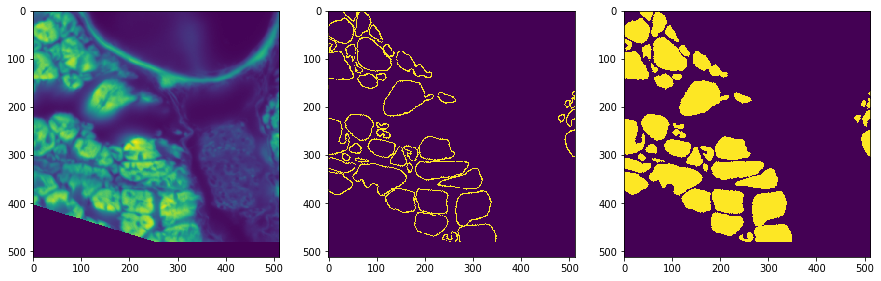

In [8]:
idx=np.random.randint(0,train_data.shape[0])
utils.plot_3x1(train_data[idx,:,:,0], train_truth[idx,:,:,0], train_truth[idx,:,:,1])

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [16]:
tf.reset_default_graph()
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 512,512,1], name='x')
y=tf.placeholder(dtype=tf.float32, shape=[None, 512,512,2], name='y')
lr=tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate')
dr=tf.placeholder(dtype=tf.float32, shape=[], name='dropout_rate')

regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)

xr=x
yr=y

base_scaler=32

#Going down
A1=utils.leaky_relu(tf.layers.conv2d(xr, base_scaler, [5,5], padding='SAME', kernel_regularizer=regularizer))
A2=utils.leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=utils.leaky_relu(tf.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
B2=utils.leaky_relu(tf.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=utils.leaky_relu(tf.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
C2=utils.leaky_relu(tf.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=utils.leaky_relu(tf.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
D2=utils.leaky_relu(tf.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=utils.leaky_relu(tf.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
E2=utils.leaky_relu(tf.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

#Coming up
DD0=tf.layers.conv2d_transpose(E2, 8*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=utils.leaky_relu(tf.layers.conv2d(DD1, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
DD3=utils.leaky_relu(tf.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

CC0=tf.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=utils.leaky_relu(tf.layers.conv2d(CC1, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
CC3=utils.leaky_relu(tf.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

BB0=tf.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
#BB0=tf.contrib.layers.conv2d_transpose(C2, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=utils.leaky_relu(tf.layers.conv2d(BB1, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
BB3=utils.leaky_relu(tf.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

AA0=tf.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], strides=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,A2])
AA2=utils.leaky_relu(tf.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))
AA3=utils.leaky_relu(tf.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME', kernel_regularizer=regularizer))

logits=utils.leaky_relu(tf.layers.conv2d(AA3, 2, [1,1], padding='SAME', kernel_regularizer=regularizer))
probs=tf.tanh(logits, name='probabilities')

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
#Added this to make the outlines more potent in error function
OutError, MaskError=tf.split(LSQ, [1,1], 3)
loss=1*tf.reduce_mean(OutError)+0.1*tf.reduce_mean(MaskError)
#loss=tf.reduce_mean(LSQ, name='error')
l2_loss = tf.losses.get_regularization_loss()
#loss=loss+l2_loss/1000

train_op=tf.train.AdamOptimizer(learning_rate=lr, name='trainer').minimize(loss)

tf.summary.scalar('loss', loss)
#tf.summary.image('input', x, 4)
#tf.summary.image('standard', y, 4)
#tf.summary.image('processed', probs, 4)


merge = tf.summary.merge_all()

# Training on easy set

0
Training loss:  0.077938184
(4, 512, 512, 2)
Validation loss:  13311.959


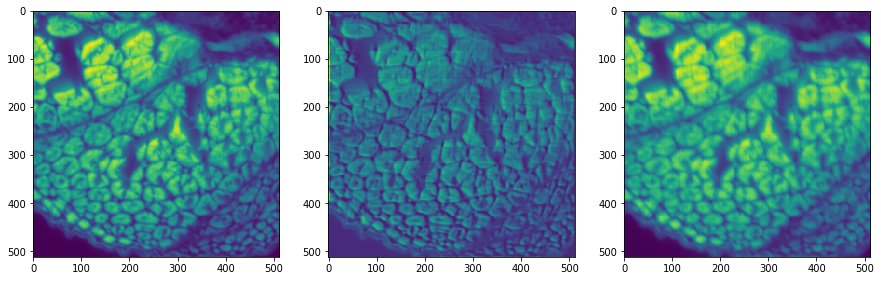

100
Training loss:  0.06403276
(4, 512, 512, 2)
Validation loss:  13285.294


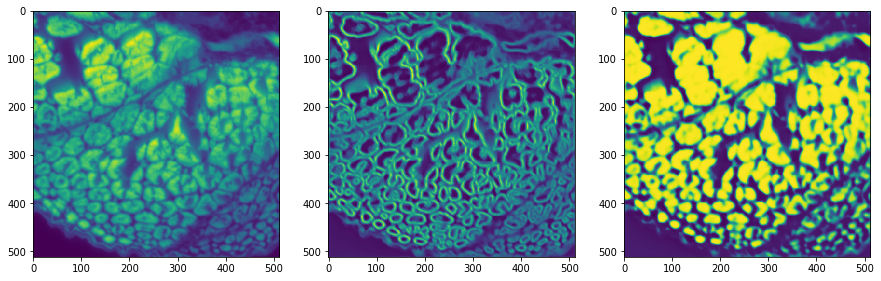

200
Training loss:  0.047423404
(4, 512, 512, 2)
Validation loss:  13293.597


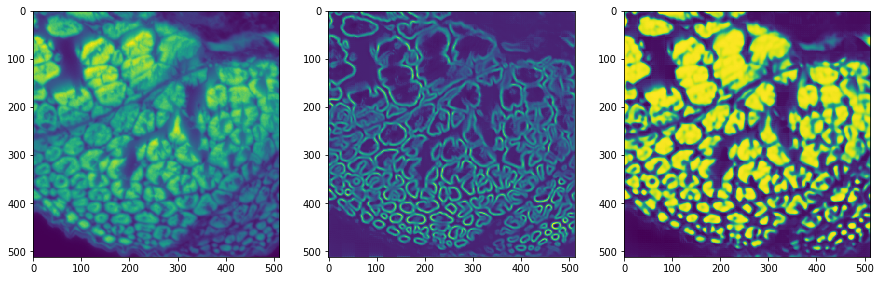

300
Training loss:  0.048437867
(4, 512, 512, 2)
Validation loss:  13289.892


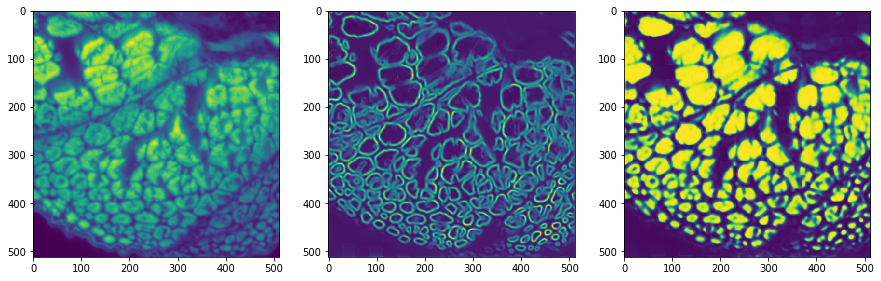

400
Training loss:  0.041312207
(4, 512, 512, 2)
Validation loss:  13293.777


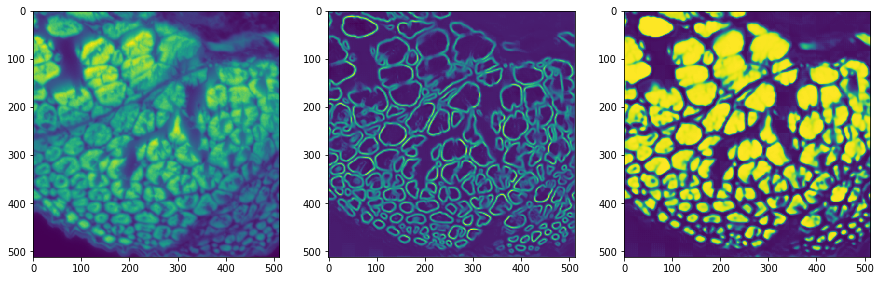

500
Training loss:  0.037051823
(4, 512, 512, 2)
Validation loss:  13287.868


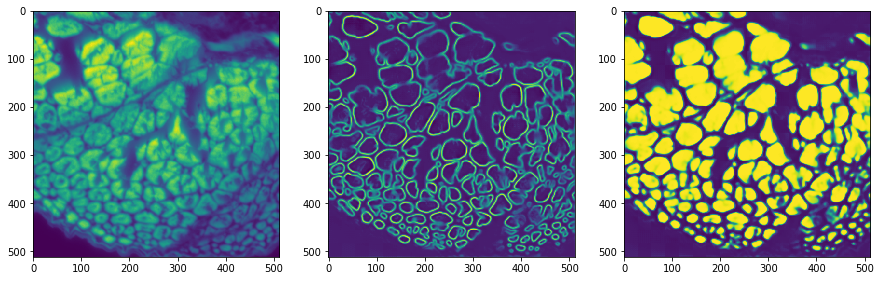

600
Training loss:  0.030597564
(4, 512, 512, 2)
Validation loss:  13290.906


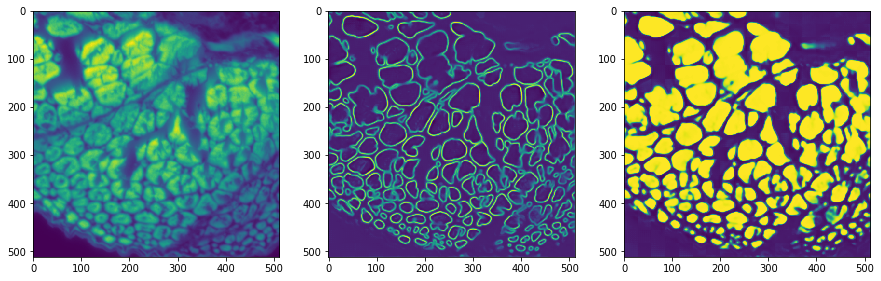

700
Training loss:  0.026981158
(4, 512, 512, 2)
Validation loss:  13288.746


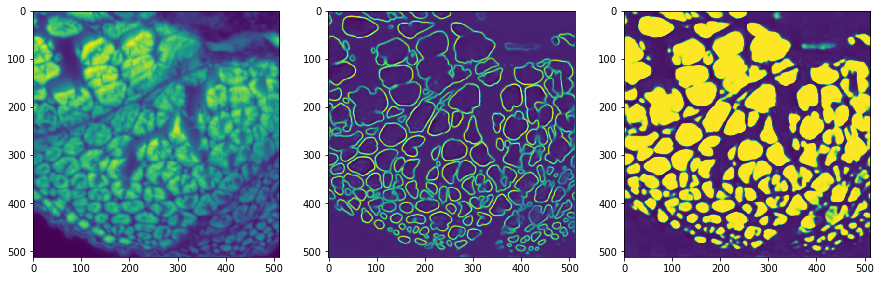

KeyboardInterrupt: 

In [17]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=50)
#train_writer = tf.summary.FileWriter('./logs/1/train ', sess.graph)
test_writer = tf.summary.FileWriter('./logs/175/test ')


learning_rates=[0.000195, 0.0001, 0.00002, 0.00001]
learning_rate_steps=[500,1500, 2200, 5200]
current_step=0
for lrate, lrs in zip(learning_rates, learning_rate_steps):
    for i in range(current_step, lrs):
        idx=np.random.choice(train_data.shape[0], replace=False, size=[25])
        cur_train=train_data[idx,:,:,:]+0*np.random.uniform(-0.5, 0.5, 1)
        cur_truth=train_truth[idx,:,:]
        _, results, losses=sess.run([train_op,  probs, loss], feed_dict={x:cur_train, y:cur_truth, lr:lrate})
        #train_writer.add_summary(summary, i)
        if (i%100==0):
            print(i)
            print("Training loss: ",losses)
            #idx=np.random.choice(validation_data.shape[0], replace=False, size=[50])
            idx=range(0,4, 1)
            sub_validation_data=validation_data[idx, :,:,:]
            sub_validation_truth=validation_truth[idx, :,:]
            summary, results, losses, a,c,cc=sess.run([merge, probs, loss, A1,C2,CC2], feed_dict={x:sub_validation_data, y:sub_validation_truth})
            test_writer.add_summary(summary, i)
            print(results.shape)
            print("Validation loss: ",losses)
            for ti in range (0,1):
                utils.plot_3x1(sub_validation_data[ti,:,:,0], results[ti,:,:,0], results[ti,:,:,1])
                plt.show()
            saver.save(sess, data+'NewModels/Model'+str(i))
    current_step=lrs

# Process new datafiles using trained network

Load the network that works best

In [32]:
saver = tf.train.Saver()
sess=tf.Session()
sess.run(tf.global_variables_initializer())

data_model=data+'NewModels/Model500'
saver.restore(sess,data_model)

Function for processing a file

In [19]:
print([mean, std])

NameError: name 'mean' is not defined

In [29]:
def process_file(sess, file_name):
    file_data=utils.get_raw_float_image(file_name, [1,512,512,1])
    file_data=np.reshape(file_data, [file_data.shape[0], 512, 512, 1])
    true_test2_data=file_data[:,:,:,[0]]/65535.0
    file_data=0
    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    #true_test2_data=true_test2_data/np.std(true_test2_data)*0.02
    #true_test2_data=true_test2_data-np.mean(true_test2_data)+0.55
    true_test2_data=(true_test2_data)/.18

    print(np.std(true_test2_data))
    print(np.mean(true_test2_data))
    
    
    num_images=true_test2_data.shape[0]
    output=np.zeros([num_images,512,512,2])
    process_batch_size=20
    print('Starting')
    for t in range(0,num_images,process_batch_size):
        endrng=np.min((t+process_batch_size,num_images))
        sub_validation_data=true_test2_data[t:(t+process_batch_size), :,:,:]
        results=sess.run(probs, feed_dict={x:sub_validation_data})
        output[t:(t+process_batch_size),:,:,0]=results[:,:,:,0]
        output[t:(t+process_batch_size),:,:,1]=results[:,:,:,1]
    print('Done')
    true_test2_data=0
    output=np.swapaxes(np.swapaxes(output,3,2),2,1)
    np.place(output, output<0, 0)
    (output*255.0).astype(np.uint8).tofile(file_name[0:-4]+'_output.raw')
    print(file_name[0:-4]+'_output.raw')
    return output


In [24]:
output=process_file(sess,data+'Reg_3mpa_6nm_1.raw')

FileNotFoundError: [Errno 2] No such file or directory: '/n/core/micro/nro/lo2296/smc/MuscleFibers/DL/Reg_3mpa_6nm_1.raw'

In [33]:
import glob
for f in glob.glob('/n/core/micro/nro/lo2296/smc/MuscleFibers/'+'*.raw'):
    output=process_file(sess, f)

0.1108561
0.11783714
0.61586744
0.6546511
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/S-3_output.raw
0.29292905
0.2544542
1.627384
1.4136347
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/P-6_output.raw
0.08001862
0.071872614
0.4445479
0.39929223
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/S-4_output.raw
0.23890275
0.19875559
1.327237
1.1041962
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/P-1_output.raw
0.2427234
0.21789762
1.3484639
1.2105438
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/P-4_output.raw
0.2785445
0.2537478
1.5474691
1.4097087
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/P-5_output.raw
0.10463675
0.10579039
0.581315
0.5877232
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/S-6_output.raw
0.10226404
0.1028336
0.5681334
0.57129586
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/S-2_output.raw
0.24133933
0.23237802
1.3407733
1.2909874
Starting
Done
/n/core/micro/nro/lo2296/smc/MuscleFibers/P-2

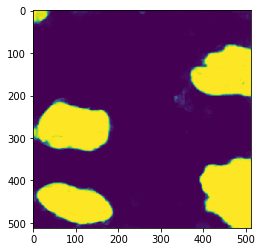

In [22]:
plt.imshow(output[10,:,:,1])